<a href="https://colab.research.google.com/github/Virtuoso633/BSSE2002-Course-Project-IITM/blob/main/TDS_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading libraries

In [ ]:
import requests
import json
import pandas as pd
import numpy as np
from urllib.parse import urljoin
from tqdm import tqdm
from time import sleep
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt

## Data Scraping

In [ ]:

def get_data_and_next_page(response_text: str):
    try:
        start_idx = response_text.find('const data =') + len('const data =')
        end_idx = response_text.rfind(';', start_idx, response_text.find('const next ='))
        data_json = response_text[start_idx:end_idx].strip()
        data = json.loads(data_json)

        start_idx = response_text.find('const next =') + len('const next =')
        end_idx = response_text.find(';', start_idx)
        next_page = response_text[start_idx:end_idx].strip().strip('"')

        return data, next_page
    except Exception as e:
        print(f"Error parsing data: {e}")
        return [], "null"

def navigate_next_page(base_url, next_page):
    if next_page != "null":
        return urljoin(base_url, next_page)
    return None

def scrape_election_data(base_url, state_entries):
    election_data = {"ID": [], "ST_NAME": [], "YEAR": [], "AC": [],
                     "CANDIDATE": [], "SEX": [], "AGE": [], "CATEGORY": [],
                     "PARTY": [], "VOTES": []}

    for entry in state_entries:
        next_page = entry['link']
        url = urljoin(base_url, next_page)
        while url:
            try:
                response = requests.get(url)
                response.raise_for_status()
                data, next_page = get_data_and_next_page(response.text)
                for row in tqdm(data, desc=f"Scraping data for year {entry['YEAR']}"):
                    for key in election_data.keys():
                        election_data[key].append(str(row.get(key, list(row.values())[0])).strip())
                url = navigate_next_page(base_url, next_page)
            except requests.RequestException as e:
                print(f"Error fetching data: {e}")
                break
    return election_data

def clean_and_save_data(state_name, ac_name, election_data):
    df = pd.DataFrame(election_data)
    df.replace('', np.nan, inplace=True)
    df = df.loc[df['VOTES'] != "None"]

    # Clean columns
    df['AC'] = df['AC'].str.replace(r'^\d+\s+', '', regex=True)
    df['AC'] = df['AC'].str.replace(r'[^a-zA-Z\s\.]', '', regex=True)
    df['CANDIDATE'] = df['CANDIDATE'].str.replace(r'^\d+\s+', '', regex=True)
    df['CANDIDATE'] = df['CANDIDATE'].str.replace(r'[^a-zA-Z\s\.]', '', regex=True)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df = df.drop_duplicates()
    df = df.drop_duplicates(subset=['ST_NAME', 'YEAR', 'AC', 'CANDIDATE', 'SEX', 'AGE', 'CATEGORY', 'PARTY', 'VOTES'])

    # Save full state data
    df.to_csv(f"{state_name}.csv", index=False)

    # Save data for specific AC
    ac_df = df[df["AC"] == ac_name]
    ac_df.to_csv(f"{state_name}_{ac_name}.csv", index=False)

def find_state_entries(start_url, state_name, n_pages=10):
    url = start_url
    state_entries = []
    for _ in tqdm(range(n_pages), desc="Crawling all pages"):
        if url:
            try:
                response = requests.get(url)
                response.raise_for_status()
                data, next_page = get_data_and_next_page(response.text)
                state_entries.extend([entry for entry in data if entry['ST_NAME'] == state_name])
                url = navigate_next_page(start_url, next_page)
            except requests.RequestException as e:
                print(f"Error during crawling: {e}")
                break
    return state_entries

def main_scraper(state_name, ac_name):
    start_url = "https://22f3001919.github.io/tds_project_1/"
    state_entries = find_state_entries(start_url, state_name)

    if not state_entries:
        print(f"No data found for state: {state_name}")
        return

    election_data = scrape_election_data(start_url, state_entries)
    clean_and_save_data(state_name, ac_name, election_data)
    return election_data


### Change the following according to your ST_NAME and AC_NAME

In [ ]:
ST_NAME = "KERALA"
AC_NAME = "THRITHALA"
# saves full state csv and also constituency csv
# scraped data undergoes priliminary cleaning as well
data = main_scraper(ST_NAME, AC_NAME)

Scraping data for year 2021: 100%|██████████| 418/418 [00:00<00:00, 44024.18it/s]


## Terminologies
- **Vote Share** - votes of the candidate divided by the total votes in that election year expressed as a percentage
- **Gap between elections** -Candidate might not contest in election in consecutive years but take a break and contest after few terms.Eg candidate 'A' contested in election conducted in 1994 and 2004 but didnot contest in the election between 1994-2004
- **Margin percentage** - difference in voteshare between contestants
- **Lose the deposit** - When the candidate failed to secure at least 1/6th of the total votes cast in that election year
- **Absolute majority** - When the candidate secures a vote share exceeding 50%


## Questions

### Q2 For the  given AC_NAME, Which election year had the most female candidates contesting an election? [string]
- If two or more years have the same number of female candidates, choose the latest year.
- If there are no female contestants then answer will be NA.

In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
elections_with_female_candidates = ac_df[ac_df["SEX"] == 'F']
print("List of years sorted in decreasing order of number of female candidates:")
elections_with_female_candidates['YEAR'].value_counts().sort_values(ascending=False)

List of years sorted in decreasing order of number of female candidates:


YEAR
2016    3
Name: count, dtype: int64

### Q4 What is the highest margin percentage by which the winning candidate has defeated the runner up in any election? Give your answer to 2 decimal places. [float]

In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
runner_ups = ac_df.drop(winners.index)
runner_ups = ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]
total_votes = ac_df.groupby('YEAR')['VOTES'].sum().values
winners["VOTE_SHARE"] = 100 * ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
runner_ups["VOTE_SHARE"] = 100 * ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
margins = winners["VOTE_SHARE"].values - runner_ups["VOTE_SHARE"].values
margins.max()

23.678906749250352

### Q5 For the given AC_NAME, In which year did the winning candidate have the biggest margin percentage win over the runner up? [string]
- If there are two or more years with the same winning margin, choose the latest one


In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
runner_ups = ac_df.drop(winners.index)
runner_ups = ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]
total_votes =  ac_df.groupby('YEAR')['VOTES'].sum().values
winners["VOTE_SHARE"] = 100 * ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
runner_ups["VOTE_SHARE"] = 100 * ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
winners["MARGIN"] = winners["VOTE_SHARE"].values - runner_ups["VOTE_SHARE"].values
print("List of years sorted in decreasing order of margin with runner up:")
winners.groupby("YEAR")["MARGIN"].sum().sort_values(ascending=False)

List of years sorted in decreasing order of margin with runner up:


YEAR
1967    23.678907
1977    16.679245
1965    15.696672
2016     7.479028
1991     5.919386
2006     5.678865
1996     4.501473
1987     3.653787
2011     2.617917
1970     2.128940
2021     1.980159
1980     1.034961
1982     0.616480
2001     0.429976
Name: MARGIN, dtype: float64

### Q7 For the  given AC_NAME,  In which year was the difference between the first and last candidates votes the biggest? [string]
- If two or more years have the same difference in votes, then choose the latest year.

In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
df_sorted = ac_df.sort_values(by=['YEAR', 'VOTES'], ascending=[True, False])
grouped = df_sorted.groupby('YEAR')
def vote_difference(group):
    return group.iloc[0]['VOTES'] - group.iloc[-1]['VOTES']

differences = grouped.apply(vote_difference)
print("List of years sorted in decreasing order of difference between first and last candidate:")
differences.sort_values(ascending=False)

List of years sorted in decreasing order of difference between first and last candidate:


YEAR
2021    69769.0
2016    66306.0
2011    57481.0
2006    56072.0
2001    47734.0
1996    45966.0
1991    45286.0
1987    39667.0
1982    28991.0
1970    23162.0
1967    22037.0
1965    21154.0
1977     9724.0
1980      619.0
dtype: float64

### Q10 What is the latest year in which the winner won more than 50 percent of the vote? [string]
- If no one got more than 50 percent of the vote, then the answer is NA


In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
total_votes =  ac_df.groupby('YEAR')['VOTES'].sum().values
winners["VOTE_SHARE"] = 100 * ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
winners_above_50 = winners[winners["VOTE_SHARE"] > 50]
winners_above_50["YEAR"].max()

1980

### Q11 For the  given AC_NAME, Which party won the highest number of election in a given constituency? [string]
- If two or more parties have the same number of highest wins, choose the party that is alphabetically first
- If independent candidates won the highest number of elections then the answer is IND


In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
print("Frequency of party winning the elections:")
winners["PARTY"].value_counts().sort_values(ascending=False)

Frequency of party winning the elections:


PARTY
INC       6
CPM       4
CPI(M)    3
IND       1
Name: count, dtype: int64

### Q14 For the given AC_NAME, What percentage of elections did female candidates win, when there was at least one female candidate in that election? Give your answer to 2 decimal places. [float]

In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
elections_with_female = ac_df.groupby('YEAR').filter(lambda x: (x['SEX'] == 'F').any())
winners = elections_with_female.loc[elections_with_female.groupby('YEAR')['VOTES'].idxmax()]
total_elections_with_female = winners['YEAR'].nunique()
female_wins = winners[winners['SEX'] == 'F']['YEAR'].nunique()
if total_elections_with_female == 0:
    percentage_female_wins = 0
else:
  percentage_female_wins = (female_wins / total_elections_with_female) * 100
percentage_female_wins

0.0

### Q15 For a given constituency, how many constituencies within the same state are less than 20 kms. Use Nominatim for this question.

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
def get_coordinates(state:str, constituency:str):
    try:
        geolocator = Nominatim(user_agent="Mozilla/5.0")
        location = geolocator.geocode(f"{constituency.lower()}, {state.lower()}, India")
        # print(location)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

def calculate_distance(given_coords, lat, lon):
    try:
        if lat and lon:
            return geodesic(given_coords, (lat, lon)).kilometers
        else:
            return None
    except:
        return None
constituency_list = {place:() for place in state_df["AC"].unique()}
estimated_time = 2.8 * len(constituency_list.keys())
print("Getting latitude and longitude for all constituencies..")
print(f"Estimated Time:{estimated_time} seconds")

for key in constituency_list.keys():
    sleep(2)
    constituency_list[key] = get_coordinates(ST_NAME, key)
print("Done")
temp_df = state_df.copy()
temp_df['LAT'], temp_df['LON'] = zip(*state_df.apply(lambda row: constituency_list[row["AC"]], axis=1))
given_coords = temp_df.loc[state_df['AC'] == AC_NAME, ['LAT', 'LON']].values[0]
temp_df['DISTANCE'] = temp_df.apply(lambda row: calculate_distance(given_coords, row['LAT'], row['LON']), axis=1)
nearby_constituencies = temp_df[(temp_df['DISTANCE'] < 20) & (temp_df['AC'] != AC_NAME)]
print("Count of constituencies within 20 kms:")
nearby_constituencies['AC'].unique().shape

Getting latitude and longitude for all constituencies..
Estimated Time:700.0 seconds


Done
Count of constituencies within 20 kms:


(6,)

### Q17 Find the Pearson correlation coefficient between the votes won by female candidates and male candidates. Only include constituencies and election years that had at least 1 female candidate. Each row in the correlation data table should represent an election. Round off the answer to 4 decimal points[float]

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
df_filtered = state_df.groupby(['YEAR', 'AC']).filter(lambda x: (x['SEX'] == 'F').any())
df_female = df_filtered[df_filtered['SEX'] == 'F'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'FEMALE_VOTES'})
female_votes_by_year = df_female.groupby('YEAR')['FEMALE_VOTES'].sum()
df_male = df_filtered[df_filtered['SEX'] == 'M'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'MALE_VOTES'})
male_votes_by_year = df_male.groupby('YEAR')["MALE_VOTES"].sum()
male_votes_by_year.corr(female_votes_by_year)

0.961713521880951

### Q18 For a given state, identify the election year which has the most outliers on the basis of candidate votes. Use the interquartile range (IQR) rule to detect outliers. [integer]

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
grouped = state_df.groupby('YEAR')
Q1 = grouped['VOTES'].transform(lambda x: x.quantile(0.25))
Q3 = grouped['VOTES'].transform(lambda x: x.quantile(0.75))
IQR = Q3 - Q1
lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR
condition = (state_df['VOTES'] < lb) | (state_df['VOTES'] > ub)
print("List of years sorted in descending order of number of outliers:")
state_df[condition]["YEAR"].value_counts()

List of years sorted in descending order of number of outliers:


YEAR
1987    279
1996    278
2016    182
1960     15
1957      8
Name: count, dtype: int64

## Essay Assignment
##(Peer-Grading Assignment)

### 1. For the given state, Use Box-Whiskers plot / violin plot to display the outliers in candidate votes for each election year. Use a different colour to clearly highlight the outliers. Do not consider candidates with NaN/null/None/blank votes. 0 votes is a valid vote count. NOTA is a valid candidate.

<ipython-input-25-83218c393ade>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(x='YEAR', y='VOTES', data=state_df, palette="coolwarm")


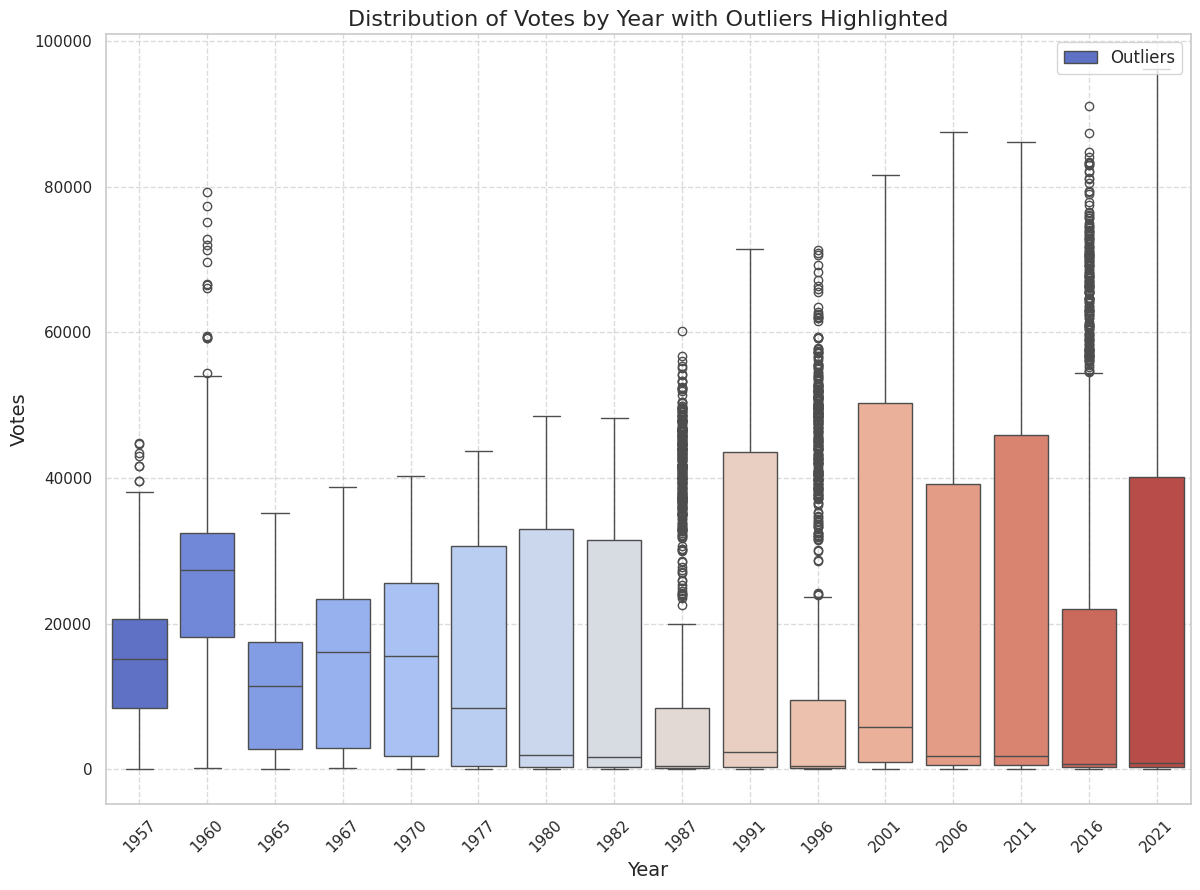

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
state_df = pd.read_csv(f"{ST_NAME}.csv")

# Filter out rows with NaN/None/blank votes
state_df = state_df[state_df['VOTES'].notna() & (state_df['VOTES'] != '') & (state_df['VOTES'] != 'None')]

# Convert 'VOTES' column to numeric
state_df['VOTES'] = pd.to_numeric(state_df['VOTES'])

# Set the theme
sns.set_theme(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(14, 10))
boxplot = sns.boxplot(x='YEAR', y='VOTES', data=state_df, palette="coolwarm")

# Highlight outliers
for i, artist in enumerate(boxplot.artists):
    artist.set_edgecolor('k')
    artist.set_facecolor('white')
    for j in range(i*6, i*6+6):
        line = boxplot.lines[j]
        line.set_color('k')
        line.set_mfc('k')
        line.set_mec('k')
    # Add outlier points with different color
    for outlier in boxplot.lines[i*6+6].get_xydata():
        plt.plot(outlier[0], outlier[1], 'ro')

# Customize plot elements
plt.title('Distribution of Votes by Year with Outliers Highlighted', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Votes', fontsize=14)
plt.xticks(rotation=45)
plt.legend(['Outliers'], loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


### 2. For the given state, Use a scatter plot to show the correlation between the length of a candidate name (string length) and the votes gathered by the candidate.



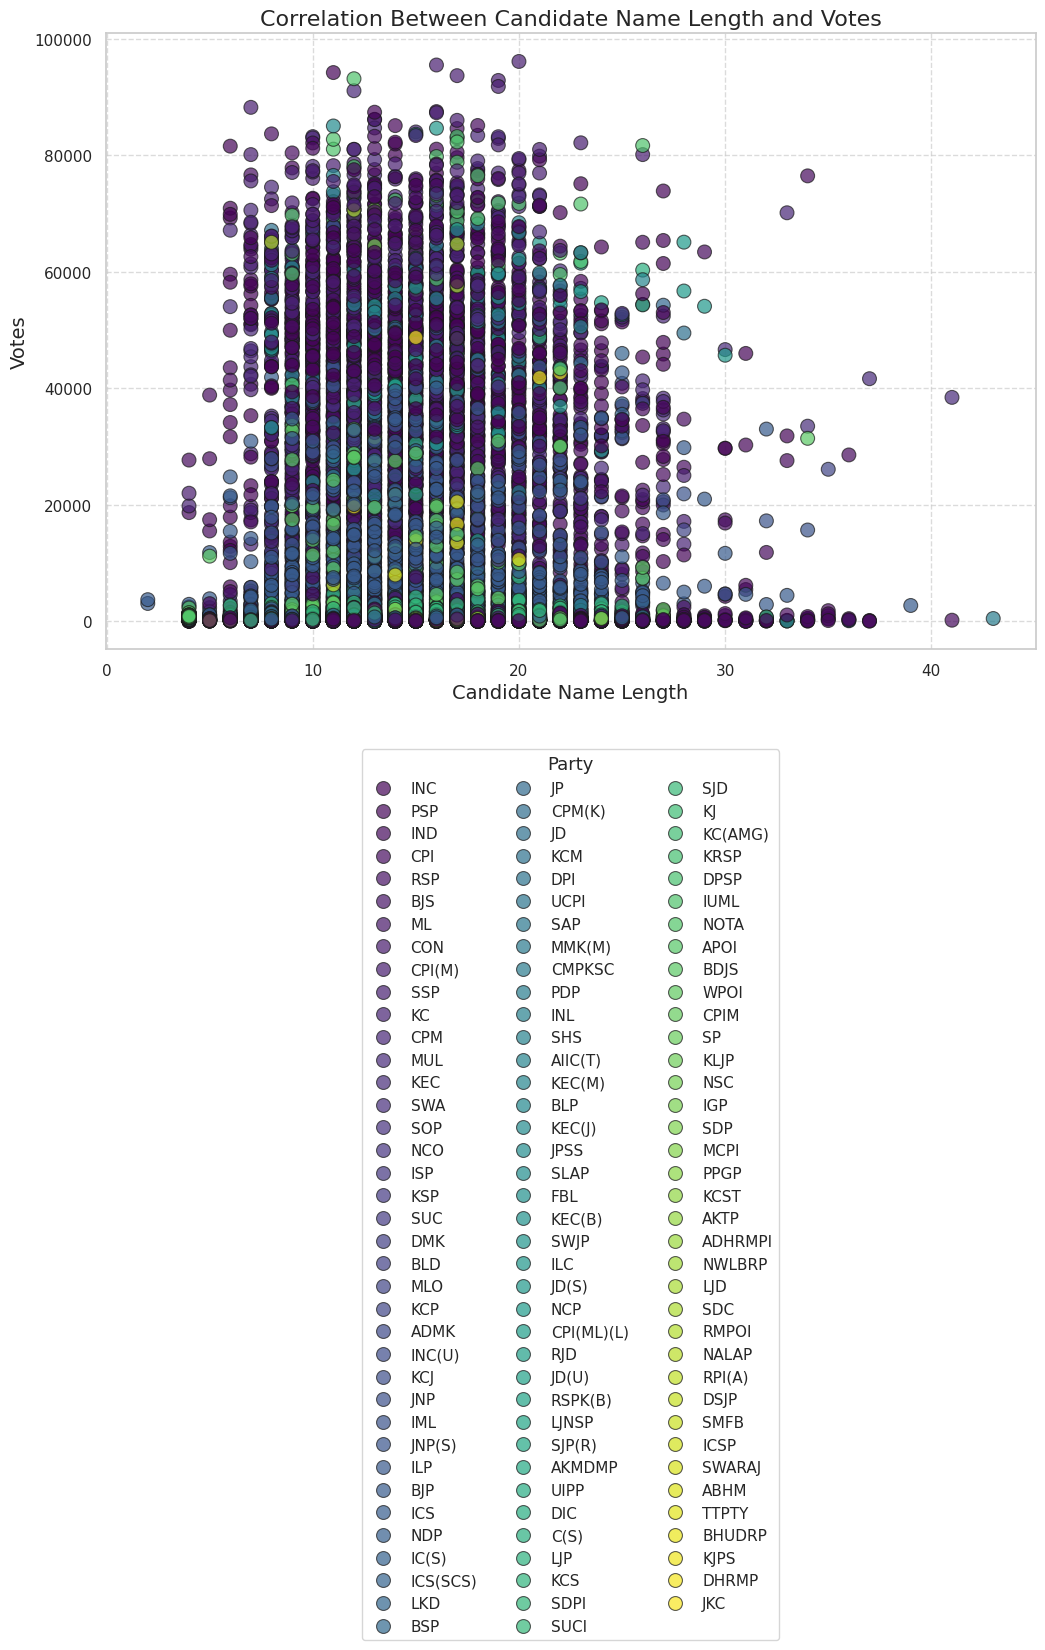

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
state_df = pd.read_csv(f"{ST_NAME}.csv")

# Calculate the name length
state_df['NAME_LENGTH'] = state_df['CANDIDATE'].apply(len)

# Set the theme
sns.set_theme(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(x='NAME_LENGTH', y='VOTES', data=state_df, hue='PARTY', palette='viridis', s=100, edgecolor='k', alpha=0.7)

# Customize plot elements
plt.title('Correlation Between Candidate Name Length and Votes', fontsize=16)
plt.xlabel('Candidate Name Length', fontsize=14)
plt.ylabel('Votes', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Place the legend below the plot
plt.legend(title='Party', title_fontsize='13', loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize='11', ncol=3)

# Show the plot
plt.show()
